### Implementing PPO in CityLearn

Import packages

In [14]:
# packages
import os
import time
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import joblib
from ipywidgets import IntProgress
from typing import List

# CityLearn
from citylearn.citylearn import CityLearnEnv
from citylearn.data import DataSet
from citylearn.reward_function import RewardFunction
from citylearn.wrappers import NormalizedObservationWrapper
from citylearn.wrappers import StableBaselines3Wrapper

# baseline RL algorithms
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor

# helper functions
from kpi_utils import get_kpis, plot_building_kpis, plot_district_kpis
from kpi_utils import plot_building_load_profiles, plot_district_load_profiles, plot_battery_soc_profiles, plot_simulation_summary
from env_utils import set_n_buildings_2022
from obs_utils import get_n_observations
from rlc_utils import CustomReward

Load data from CityLearn 2022 Challenge. 

The CityLearn Challenge 2022 focuses on the opportunity brought on by home battery storage devices and photovoltaics. It leverages CityLearn, a Gym Environment, for building distributed energy resource management and demand response. The challenge utilizes 1 year of operational electricity demand and PV generation data from 17 single-family buildings in the Sierra Crest home development in Fontana, California, that were studied for Grid integration of zero net energy communities.

Participants will develop energy management agent(s) and their reward function for battery charge and discharge control in each building to minimise the monetary cost of electricity drawn from the grid and the CO2 emissions when electricity demand is satisfied by the grid.

In [15]:
data_dir = '/home/jt9744/projects/thesis/CityLearn_thesis/data/datasets'
DATASET_NAME = 'citylearn_challenge_2022_phase_all'
ds = DataSet()
training_schema = ds.get_schema(DATASET_NAME)

Data Preprocessing:
1. Use 2, 4, or 8 buildings to measure scalability (consider using 12 and 15 if there's enough time)
2. Use centralized control

These can be modified directly in the schema. The buildings will be pseudo-randomly selected with a seed for reproducibility. 

In [16]:
n_buildings = 2 # 2, 4, or 8 
training_schema, buildings = set_n_buildings_2022(training_schema, n_buildings)
print('Number of buildings:', n_buildings)
print('Selected buildings:', buildings)
print(f'Number of observations: {get_n_observations(n_buildings)}')
# use centralized control
training_schema['central_agent'] = True

Number of buildings: 2
Selected buildings: ['Building_8', 'Building_10']
Number of observations: 32


Initialize a CityLearn Environment

In [17]:
train_env = CityLearnEnv(training_schema)

# check initialization
print('Current time step:', train_env.time_step)
print('environment number of time steps:', train_env.time_steps)
print('environment uses central agent:', train_env.central_agent)
print('Number of buildings:', len(train_env.buildings))
print('Electrical storage capacity:', {
    b.name: b.electrical_storage.capacity for b in train_env.buildings
})
print('Electrical storage nominal power:', {
    b.name: b.electrical_storage.nominal_power for b in train_env.buildings
})

Current time step: 0
environment number of time steps: 8760
environment uses central agent: True
Number of buildings: 2
Electrical storage capacity: {'Building_8': 6.4, 'Building_10': 6.4}
Electrical storage nominal power: {'Building_8': 5.0, 'Building_10': 5.0}


#### Implementing PPO 

In [18]:
# logging
log_dir = "./sb3_logs/ppo" # Directory for Monitor logs and TensorBoard logs
os.makedirs(log_dir, exist_ok=True)

# initialize environment
train_env.reward_function = CustomReward(train_env)
train_env = NormalizedObservationWrapper(train_env) # ensure all observations that are served to the agent are min-max normalized between [0, 1] and cyclical observations e.g. hour, are encoded using the sine and cosine transformation.
train_env = StableBaselines3Wrapper(train_env) # ensures observations, actions and rewards are served in manner that is compatible with Stable Baselines3 interface
train_env = Monitor(train_env, filename=os.path.join(log_dir, "monitor.csv"))
observations, info = train_env.reset()

# initialize model 
ppo_model = PPO(
    policy='MlpPolicy',
    env=train_env,
    device='cpu',
    seed=0,
    verbose=1, # Set to 1 to see SB3 logging output, including Monitor info
    tensorboard_log=os.path.join(log_dir, "logs/")
)

# train model
start_time = time.time()
ppo_model = ppo_model.learn(
    total_timesteps = training_schema['simulation_end_time_step'],
    log_interval=1
)
ppo_model.save(os.path.join(log_dir, "ppo_trained_model"))
print(f"Total time taken for training for {training_schema['simulation_end_time_step']} steps: {(time.time()-start_time) / 60:.2f} minutes")

Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to ./sb3_logs/ppo/logs/PPO_5
-----------------------------
| time/              |      |
|    fps             | 164  |
|    iterations      | 1    |
|    time_elapsed    | 12   |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2            |
|    time_elapsed         | 85           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0074532568 |
|    clip_fraction        | 0.032        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | -0.033       |
|    learning_rate        | 0.0003       |
|    loss                 | 94.1         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00898     |
|    std     

#### Evaluating PPO 

In [19]:
eval_env = CityLearnEnv(training_schema)
eval_env = NormalizedObservationWrapper(eval_env)
eval_env = StableBaselines3Wrapper(eval_env)
observations, info = eval_env.reset()

In [20]:
ppo_actions_list = []
terminated, truncated = False, False

start_time = time.time()
while not (terminated or truncated):
    actions, _ = ppo_model.predict(observations, deterministic=True)
    observations, reward, terminated, truncated, info = eval_env.step(actions)
    ppo_actions_list.append(actions)
print(f"Total time taken for evaluation: {(time.time()-start_time) / 60:.2f} minutes")

Total time taken for evaluation: 0.88 minutes


In [21]:
performance = eval_env.unwrapped.evaluate()

# filter KPIs
kpis = {'all_time_peak_average': 'Average peak cost.',
        'carbon_emissions_total': 'Rolling sum of carbon emissions.', 
        'cost_total': 'Rolling sum of electricity monetary cost.',
        'daily_one_minus_load_factor_average': 'A measure of load variability / peakiness (daily average).', 
        'daily_peak_average': 'Average daily peak cost.',
        'electricity_consumption_total': 'Rolling sum of positive electricity consumption.',
        'monthly_one_minus_load_factor_average': 'A measure of load variability / peakiness (monthly average).',
        'ramping_average': 'Average rolling sum of absolute difference in net electric consumption between consecutive time steps',
        'zero_net_energy': 'Rolling sum of net electricity consumption'}
performance = performance[performance['cost_function'].isin(kpis.keys())].reset_index(drop=True)

# save evaluation
results_dir = f'results/results_ppo_2022_centralized/{n_buildings}_buildings'
os.makedirs(results_dir, exist_ok=True)
print(f"\nSaving results to {results_dir}...")
# joblib.dump(total_actions_log_np, os.path.join(results_dir, 'total_actions.joblib'))
# joblib.dump(rewards, os.path.join(results_dir, 'rewards.joblib'))
performance.to_csv(os.path.join(results_dir, 'performance_kpis.csv'), index=False)
with open(f'{results_dir}/kpi_metadata', "w") as f:
    json.dump(kpis, f, indent=4)
    
# view evaluation
performance


Saving results to results/results_ppo_2022_centralized/2_buildings...


,cost_function,value,name,level
0,all_time_peak_average,0.935327,District,district
1,carbon_emissions_total,0.985044,District,district
2,cost_total,0.924231,District,district
3,daily_one_minus_load_factor_average,0.985640,District,district
4,daily_peak_average,0.998259,District,district
5,electricity_consumption_total,1.003717,District,district
6,monthly_one_minus_load_factor_average,0.990314,District,district
7,ramping_average,1.039290,District,district
8,zero_net_energy,1.084197,District,district
9,electricity_consumption_total,1.051241,Building_8,building


In [22]:
# set all plotted figures without margins
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

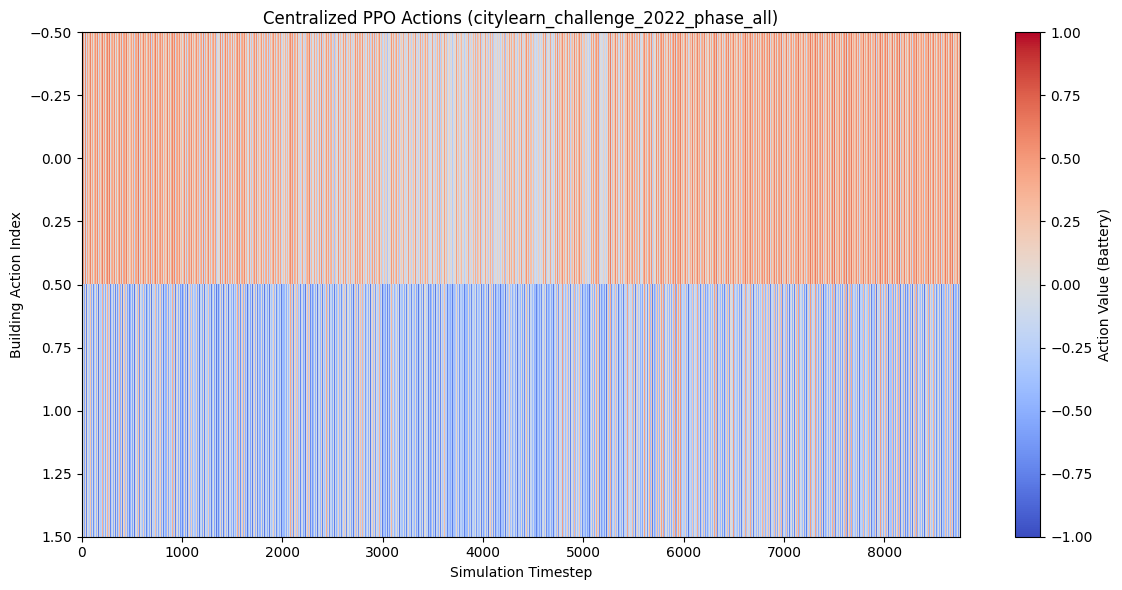

In [23]:
# Plot actions performance
plt.figure(figsize=(12, 6))
# Transpose for plotting: actions on y-axis, time on x-axis
plt.imshow(np.stack(ppo_actions_list).T, aspect='auto', interpolation='none', cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Action Value (Battery)')
plt.xlabel('Simulation Timestep')
plt.ylabel('Building Action Index')
plt.title(f'Centralized PPO Actions ({DATASET_NAME})')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'ppo_actions_heatmap.png'))
plt.show() 

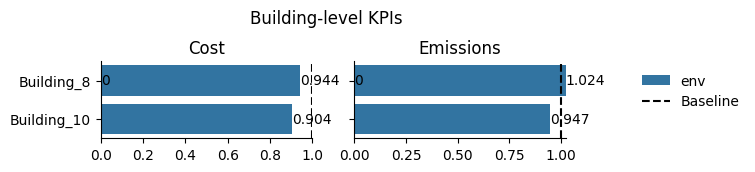

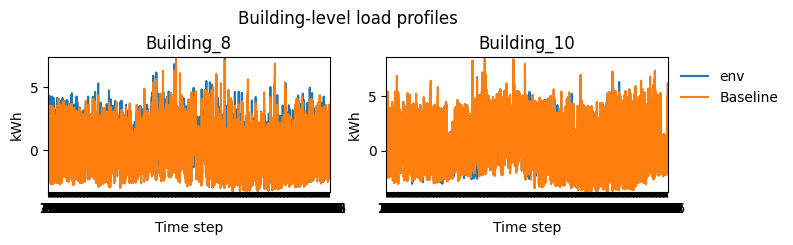

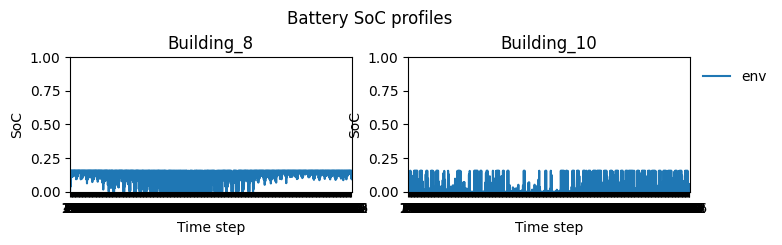

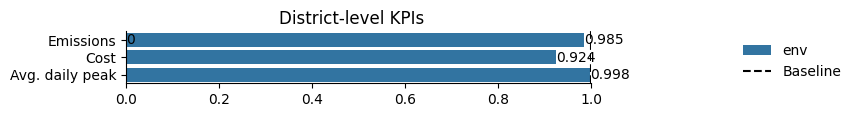

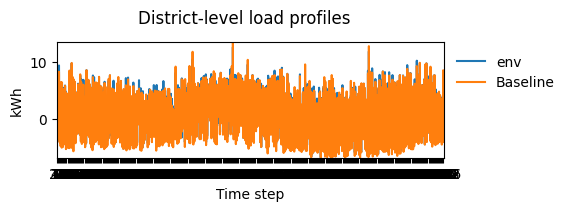

In [24]:
plots = plot_simulation_summary({'env': eval_env.unwrapped}, ret=True)
for plot_name in plots:
    plots[plot_name].savefig(f'{results_dir}/{plot_name}')

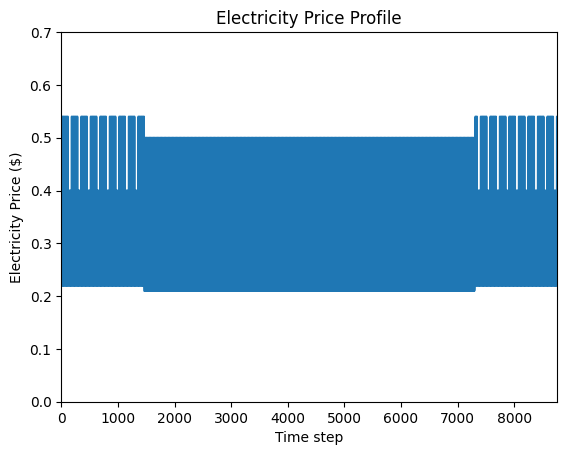

In [25]:
plt.plot(eval_env.unwrapped.buildings[0].pricing.electricity_pricing)
plt.ylim(0,0.7)
plt.ylabel('Electricity Price ($)')
plt.xlabel('Time step')
plt.title('Electricity Price Profile')
plt.savefig(os.path.join(results_dir, 'electricity_price.png'))

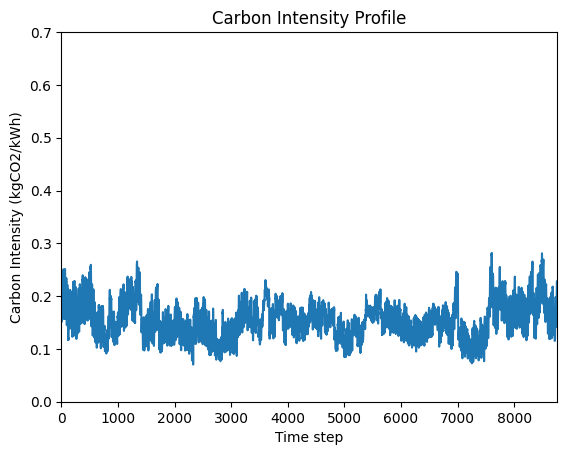

In [26]:
plt.plot(eval_env.unwrapped.buildings[0].carbon_intensity.carbon_intensity)
plt.ylim(0,0.7)
plt.ylabel('Carbon Intensity (kgCO2/kWh)')
plt.xlabel('Time step')
plt.title('Carbon Intensity Profile')
plt.savefig(os.path.join(results_dir, 'carbon_intensity.png'))